# Modeling Process

Much like EDA, the ML process is very iterative and heuristic-based. With minimal knowledge of the problem or data at hand, it is difficult to know which ML method will perform best.  This is known as the _no free lunch_ theorem for ML {cite}`wolpert1996lack`.  Consequently, it is common for many ML approaches to be applied, evaluated, and modified before a final, optimal model can be determined. Performing this process correctly provides great confidence in our outcomes. If not, the results will be useless and, potentially, damaging [^fatml].

[^fatml]: See https://www.fatml.org/resources/relevant-scholarship for many discussions regarding implications of poorly applied and interpreted ML.

Approaching ML modeling correctly means approaching it strategically by spending our data wisely on learning and validation procedures, properly pre-processing the feature and target variables, minimizing data leakage, tuning hyperparameters, and assessing model performance. Many books and courses portray the modeling process as a short sprint. A better analogy would be a marathon where many iterations of these steps are repeated before eventually finding the final optimal model. This process is illustrated in the figure below. 

![](../images/modeling_process.png)

# Learning objectives

Before introducing specific algorithms, this module, and the next, introduce concepts that are fundamental to the ML modeling process and that you will see briskly covered in future modules. By the end of this model you will be able to:

1. Split your data into training and test sets.
2. Instantiate, train, fit, and evaluate a basic model in both R and Python.
4. Apply _k_-fold resampling and hyperparameter tuning procedures to improve the robustness and performance of a model.
5. Put these steps together for an end-to-end ML process.

# Prerequisites

This section leverages the following packages. We will demonstrate concepts on the Ames housing and employee attrition data sets.

In [35]:
# Helper packages
import math
import numpy as np
import pandas as pd
from plotnine import ggplot, aes, geom_density, geom_line, geom_point, ggtitle, themes

# Data
import modeldata

# Modeling process
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, roc_auc_score

In [5]:
# Data used
ames = modeldata.load_dataset('ames')
attrition = modeldata.load_dataset('attrition')

# Data splitting

A major goal of the machine learning process is to find an algorithm $f\left(X\right)$ that most accurately predicts future values ($\hat{Y}$) based on a set of features ($X$).  In other words, we want an algorithm that not only fits well to our past data, but more importantly, one that predicts a future outcome accurately.  This is called the ___generalizability___ of our algorithm.  How we "spend" our data will help us understand how well our algorithm generalizes to unseen data.  

To provide an accurate understanding of the generalizability of our final optimal model, we can split our data into training and test data sets:

*  __Training set__: these data are used to develop feature sets, train our algorithms, tune hyperparameters, compare models, and all of the other activities required to choose a final model (e.g., the model we want to put into production).
*  __Test set__: having chosen a final model, these data are used to estimate an unbiased assessment of the model’s performance, which we refer to as the _generalization error_. 

![](../images/data_split.png)

```{warning}
It is critical that the test set not be used prior to selecting your final model. Assessing results on the test set prior to final model selection biases the model selection process since the testing data will have become part of the model development process.
```

Given a fixed amount of data, typical recommendations for splitting your data into training-test splits include 60% (training)--40% (testing), 70%--30%, or 80%--20%. Generally speaking, these are appropriate guidelines to follow; however, it is good to keep the following points in mind:

* Spending too much in training (e.g., $>80\%$) won't allow us to get a good assessment of predictive performance.  We may find a model that fits the training data very well, but is not generalizable (_overfitting_).
* Sometimes too much spent in testing ($>40\%$) won't allow us to get a good assessment of model parameters.

Other factors should also influence the allocation proportions. For example, very large training sets (e.g., $n > 100\texttt{K}$) often result in only marginal gains compared to smaller sample sizes.  Consequently, you may use a smaller training sample to increase computation speed (e.g., models built on larger training sets often take longer to score new data sets in production).  In contrast, as $p \geq n$ (where $p$ represents the number of features), larger samples sizes are often required to identify consistent signals in the features.

The two most common ways of splitting data include ___simple random sampling___ and ___stratified sampling___.

## Simple random sampling

The simplest way to split the data into training and test sets is to take a simple random sample. This does not control for any data attributes, such as the distribution of your response variable ($Y$). 

```{note}
Sampling is a random process so setting the random number generator with a common seed allows for reproducible results.  Throughout this course we'll often use the seed `123` for reproducibility but the number itself has no special meaning.
```

In [6]:
# create train/test split
train, test = train_test_split(ames, train_size=0.7, random_state=123)

# dimensions of training data
train.shape

(2051, 74)

With sufficient sample size, this sampling approach will typically result in a similar distribution of $Y$ (e.g., `Sale_Price` in the `ames` data) between your <font color="blue">training</font> and <font color="red">test</font> sets, as illustrated below.


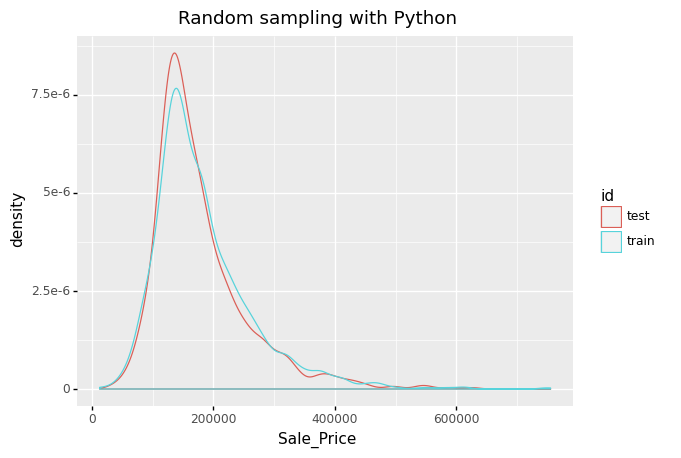

<ggplot: (8763880063211)>

In [9]:
train['id'] = 'train'
test['id'] = 'test'

(ggplot(pd.concat([train, test]), aes('Sale_Price', color='id'))
 + geom_density()
 + ggtitle("Random sampling with Python"))

## Stratified sampling

If we want to explicitly control the sampling so that our training and test sets have similar $Y$ distributions, we can use stratified sampling.  This is more common with classification problems where the response variable may be severely imbalanced (e.g., 90% of observations with response "Yes" and 10% with response "No"). However, we can also apply stratified sampling to regression problems for data sets that have a small sample size and where the response variable deviates strongly from normality.  With a continuous response variable, stratified sampling will segment $Y$ into quantiles and randomly sample from each.  

To perform stratified sampling in Python we simply apply the `stratify` argument in `train_test_split()`.


In [10]:
y = attrition["Attrition"]
train_strat, test_strat = train_test_split(
    attrition, 
    train_size=0.3, 
    random_state=123,
    stratify=y
    )

The following illustrates that in our original employee attrition data we have an imbalanced response (No: 84%, Yes: 16%). By enforcing stratified sampling, both our training and testing sets have approximately equal response distributions. 


In [16]:
for data_set in [attrition, train_strat, test_strat]:
    print(data_set["Attrition"].value_counts(normalize=True))

No     0.838776
Yes    0.161224
Name: Attrition, dtype: float64
No     0.839002
Yes    0.160998
Name: Attrition, dtype: float64
No     0.838678
Yes    0.161322
Name: Attrition, dtype: float64


## Class imbalances

Imbalanced data can have a significant impact on model predictions and performance {cite}`apm`.  Most often this involves classification problems where one class has a very small proportion of observations (e.g., defaults - 5% versus nondefaults - 95%). Several sampling methods have been developed to help remedy class imbalance and most of them can be categorized as either _up-sampling_ or _down-sampling_.

Down-sampling balances the dataset by reducing the size of the abundant class(es) to match the frequencies in the least prevalent class. This method is used when the quantity of data is sufficient. By keeping all samples in the rare class and randomly selecting an equal number of samples in the abundant class, a balanced new dataset can be retrieved for further modeling. Furthermore, the reduced sample size reduces the computation burden imposed by further steps in the ML process.

On the contrary, up-sampling is used when the quantity of data is insufficient. It tries to balance the dataset by increasing the size of rarer samples. Rather than getting rid of abundant samples, new rare samples are generated by using repetition or bootstrapping.

```{note}
There is no absolute advantage of one sampling method over another. Application of these two methods depends on the use case it applies to and the data set itself. A combination of over- and under-sampling is often successful and a common approach is known as Synthetic Minority Over-Sampling Technique, or SMOTE {cite}`chawla2002smote`. 
```

# Creating models

Throughout this book we will apply many different models so you should become quite comfortable with the process. The process of fitting a model is relatively simple and, in many cases (i.e. Scikit-learn), follows a very common pattern.

In Python, we are often required to separate our features from our label into discrete data sets. For our first model we will simply use two features from our training data - total square feet of the home (`Gr_Liv_Area`) and year built (`Year_Built`) to predict the sale price. 

Scikit-learn has many modules for different model types. One module is the [`sklearn.neighbors`](https://scikit-learn.org/stable/modules/neighbors.html) which contains various methods for unsupervised and supervised neighbors-based learning models. In our example, we are going to apply a K-Nearest neighbor regression model since `Sale_Price` is a continuous response. We'll use `KNeighborsRegressor` to do so and in this example we'll simply fit our model to 10 neighbors. 

```{note}
We will discuss K-Nearest neighbor (KNN) models in detail in a later module but for now just consider we are trying to predict the price of a home based on the average price of 10 other homes that seem to be most similar it.
```

First we create the model object (`knn`) and then fit the model to our training data.

In [56]:
# separate features from labels
X_train = train[["Gr_Liv_Area", "Year_Built"]]
y_train = train["Sale_Price"]

# fit a KNN regression model with 10 neighbors
knn = KNeighborsRegressor(n_neighbors=10)
m1 = knn.fit(X_train, y_train)
m1

KNeighborsRegressor(n_neighbors=10)

We have fit our model, if we want to see our predictions we can simply apply `predict()` and feed it the data set we want to make predictions on:

In [57]:
m1.predict(X_train)

array([203900. , 129440. , 147725. , ..., 342814.3, 183370. , 142476.9])

# Evaluating models

It is important to understand how our model is performing. With ML models, measuring performance means understanding the predictive accuracy -- the difference between a predicted value and the actual value. We measure predictive accuracy with ___loss functions___.

There are many loss functions to choose from when assessing the performance of a predictive model, each providing a unique understanding of the predictive accuracy and differing between regression and classification models. Furthermore, the way a loss function is computed will tend to emphasize certain types of errors over others and can lead to drastic differences in how we interpret the “optimal model”. Its important to consider the problem context when identifying the preferred performance metric to use. And when comparing multiple models, we need to compare them across the same metric.

## Regression models

* __MSE__: Mean squared error is the average of the squared error ($MSE = \frac{1}{n} \sum^n_{i=1}(y_i - \hat y_i)^2$)^[This deviates slightly from the usual definition of MSE in ordinary linear regression, where we divide by $n-p$ (to adjust for bias) as opposed to $n$.]. The squared component results in larger errors having larger penalties.  This (along with RMSE) is the most common error metric to use. __Objective: minimize__

* __RMSE__: Root mean squared error.  This simply takes the square root of the MSE metric ($RMSE = \sqrt{\frac{1}{n} \sum^n_{i=1}(y_i - \hat y_i)^2}$) so that your error is in the same units as your response variable. If your response variable units are dollars, the units of MSE are dollars-squared, but the RMSE will be in dollars. __Objective: minimize__

* __Deviance__: Short for mean residual deviance. In essence, it provides a degree to which a model explains the variation in a set of data when using maximum likelihood estimation. Essentially this compares a saturated model (i.e. fully featured model) to an unsaturated model (i.e. intercept only or average). If the response variable distribution is Gaussian, then it will be approximately equal to MSE.  When not, it usually gives a more useful estimate of error. Deviance is often used with classification models. [^deviance] __Objective: minimize__

[^deviance]: See this StackExchange thread (http://bit.ly/what-is-deviance) for a good overview of deviance for different models and in the context of regression versus classification.

* __MAE__: Mean absolute error. Similar to MSE but rather than squaring, it just takes the mean absolute difference between the actual and predicted values ($MAE = \frac{1}{n} \sum^n_{i=1}(\vert y_i - \hat y_i \vert)$). This results in less emphasis on larger errors than MSE. __Objective: minimize__

* __RMSLE__: Root mean squared logarithmic error. Similar to RMSE but it performs a `log()` on the actual and predicted values prior to computing the difference ($RMSLE = \sqrt{\frac{1}{n} \sum^n_{i=1}(log(y_i + 1) - log(\hat y_i + 1))^2}$). When your response variable has a wide range of values, large response values with large errors can dominate the MSE/RMSE metric. RMSLE minimizes this impact so that small response values with large errors can have just as meaningful of an impact as large response values with large errors. __Objective: minimize__

* $R^2$: This is a popular metric that represents the proportion of the variance in the dependent variable that is predictable from the independent variable(s). Unfortunately, it has several limitations. For example, two models built from two different data sets could have the exact same RMSE but if one has less variability in the response variable then it would have a lower $R^2$ than the other. You should not place too much emphasis on this metric. __Objective: maximize__

Most models we assess in this book will report most, if not all, of these metrics.  We will emphasize MSE and RMSE but it's important to realize that certain situations warrant emphasis on some metrics more than others.

The following illustrates how to compute the MSE and RMSE for our training set.

In [58]:
pred = m1.predict(X_train)

# compute MSE
mse = mean_squared_error(y_train, pred)
mse

1845902403.308791

In [59]:
# compute RMSE
mean_squared_error(y_train, pred, squared=False)

42963.9663358586

## Classification models

* __Misclassification__: This is the overall error.  For example, say you are predicting 3 classes ( _high_, _medium_, _low_ ) and each class has 25, 30, 35 observations respectively (90 observations total). If you misclassify 3 observations of class _high_, 6 of class _medium_, and 4 of class _low_, then you misclassified 13 out of 90 observations resulting in a 14% misclassification rate. __Objective: minimize__

* __Mean per class error__\index{mean per class error}: This is the average error rate for each class. For the above example, this would be the mean of $\frac{3}{25}, \frac{6}{30}, \frac{4}{35}$, which is 14.5%. If your classes are balanced this will be identical to misclassification. __Objective: minimize__

* __MSE__: Mean squared error. Computes the distance from 1.0 to the probability suggested. So, say we have three classes, A, B, and C, and your model predicts a probability of 0.91 for A, 0.07 for B, and 0.02 for C. If the correct answer was A the $MSE = 0.09^2 = 0.0081$, if it is B $MSE = 0.93^2 = 0.8649$, if it is C $MSE = 0.98^2 = 0.9604$. The squared component results in large differences in probabilities for the true class having larger penalties. __Objective: minimize__

* __Cross-entropy (aka Log Loss or Deviance)__: Similar to MSE but it incorporates a log of the predicted probability multiplied by the true class.  Consequently, this metric disproportionately punishes predictions where we predict a small probability for the true class, which is another way of saying having high confidence in the wrong answer is really bad. __Objective: minimize__

* __Gini index__\index: Mainly used with tree-based methods and commonly referred to as a measure of _purity_ where a small value indicates that a node contains predominantly observations from a single class. __Objective: minimize__

When applying classification models, we often use a _confusion matrix_ to evaluate certain performance measures. A confusion matrix is simply a matrix that compares actual categorical levels (or events) to the predicted categorical levels. When we predict the right level, we refer to this as a _true positive_.  However, if we predict a level or event that did not happen this is called a _false positive_ (i.e. we predicted a customer would redeem a coupon and they did not). Alternatively, when we do not predict a level or event and it does happen that this is called a _false negative_ (i.e. a customer that we did not predict to redeem a coupon does). 

![](../images/confusion-matrix.png)

We can extract different levels of performance for binary classifiers.  For example, given the classification (or confusion) matrix illustrated above we can assess the following:

* __Accuracy__: Overall, how often is the classifier correct? Opposite of misclassification above. Example: $\frac{TP + TN}{total} = \frac{100+50}{165} = 0.91$.  __Objective: maximize__ 

* __Precision__: How accurately does the classifier predict events? This metric is concerned with maximizing the true positives to false positive ratio. In other words, for the number of predictions that we made, how many were correct?  Example: $\frac{TP}{TP + FP} = \frac{100}{100+10} = 0.91$.  __Objective: maximize__

* __Sensitivity (aka recall)__: How accurately does the classifier classify actual events? This metric is concerned with maximizing the true positives to false negatives ratio. In other words, for the events that occurred, how many did we predict?  Example: $\frac{TP}{TP + FN} = \frac{100}{100+5} = 0.95$.  __Objective: maximize__

* __Specificity__: How accurately does the classifier classify actual non-events? Example: $\frac{TN}{TN + FP} = \frac{50}{50+10} = 0.83$.  __Objective: maximize__


![](../images/confusion-matrix2.png)

* __AUC__: Area under the curve. A good binary classifier will have high precision and sensitivity.  This means the classifier does well when it predicts an event will and will not occur, which minimizes false positives and false negatives.  To capture this balance, we often use a ROC curve that plots the false positive rate along the x-axis and the true positive rate along the y-axis.  A line that is diagonal from the lower left corner to the upper right corner represents a random guess. The higher the line is in the upper left-hand corner, the better.  AUC computes the area under this curve. __Objective: maximize__

![](../images/modeling-process-roc-1.png)

The following is an example of computing the AUC for classification models developed on the Attrition data in Python. Do not be too concerned with understanding all the nuances. The main thing to note is in both cases we follow a similar procedure of fitting our model, computing predicted values, and then comparing the the predicted values to the actual values.


In [22]:
# convert response to binary ints
train_strat["Attrition"].replace(('Yes', 'No'), (1, 0), inplace=True)

# separate features from labels
X_train_strat = train_strat[["DistanceFromHome"]]
y_train_strat = np.array(train_strat["Attrition"])

# fit a KNN regression model with 10 neighbors
knn2 = KNeighborsClassifier(n_neighbors=10)
m2 = knn2.fit(X_train_strat, y_train_strat)

# make predictions
pred = m2.predict_proba(X_train_strat)

# compute AUC
roc_auc_score(y_train_strat, pred[:, 1])

0.6381423677198325

# Resampling methods

In the data splitting section we split our data into training and testing sets. Furthermore, we were very explicit about the fact that we ___do not___ use the test set to assess model performance during the training phase. So how do we assess the generalization performance of the model? 

One option is to assess an error metric based on the training data, which demonstrated in the last section. Unfortunately, this leads to biased results as some models can perform very well on the training data but not generalize well to a new data set. 

A second method is to use a _validation_ approach, which involves splitting the training set further to create two parts: a training set and a validation set (or _holdout set_).  We can then train our model(s) on the new training set and estimate the performance on the validation set. Unfortunately, validation using a single holdout set can be highly variable and unreliable unless you are working with very large data sets {cite}`molinaro2005prediction, hawkins2003assessing`. As the size of your data set reduces, this concern increases.

```{note}
Although we stick to our definitions of test, validation, and holdout sets, these terms are sometimes used interchangeably in other literature and software. What's important to remember is to always put a portion of the data under lock and key until a final model has been selected (we refer to this as the test data, but others refer to it as the holdout set).
```

___Resampling methods___ provide an alternative approach by allowing us to repeatedly fit a model of interest to parts of the training data and test its performance on other parts.  The two most commonly used resampling method include _k-fold cross validation_ and _bootstrap sampling_.  

## _k_-fold cross validation 

_k_-fold cross-validation (aka _k_-fold CV) is a resampling method that randomly divides the training data into _k_ groups (aka folds) of approximately equal size. The model is fit on $k-1$ folds and then the remaining fold is used to compute model performance.  This procedure is repeated _k_ times; each time, a different fold is treated as the validation set. This process results in _k_ estimates of the generalization error (say $\epsilon_1, \epsilon_2, \dots, \epsilon_k$). Thus, the _k_-fold CV estimate is computed by averaging the _k_ test errors, providing us with an approximation of the error we might expect on unseen data.

![](../images/cv.png)

Consequently, with _k_-fold CV, every observation in the training data will be held out one time to be included in the test set as illustrated in the figure below.  In practice, one typically uses $k = 5$ or $k = 10$. There is no formal rule as to the size of _k_; however, as _k_ gets larger, the difference between the estimated performance and the true performance to be seen on the test set will decrease.  On the other hand, using too large _k_ can introduce computational burdens.  Moreover, {cite}`molinaro2005prediction` found that $k=10$ performed similarly to leave-one-out cross validation (LOOCV) which is the most extreme approach (i.e., setting $k = n$).

The following is an illustration of 10-fold cross validation on 32 observations. Each observation is used once for validation and nine times for training.

![](../images/modeling-process-cv-1.png)

Although using $k \geq 10$ helps to minimize the variability in the estimated performance, _k_-fold CV still tends to have higher variability than bootstrapping.  {cite}`kim2009estimating` showed that repeating _k_-fold CV can help to increase the precision of the estimated generalization error.  Consequently, for smaller data sets (say $n < 10,000$), 10-fold CV repeated 5 or 10 times will improve the accuracy of your estimated performance and also provide an estimate of its variability.

In Python we use `KFold`, `RepeatedKFold` to create k-fold objects and then `cross_val_score` to train our model across all *k* folds and provide our loss score for each fold.

```{note}
The unified scoring API in scikit-learn always maximizes the score, so scores which need to be minimized are negated in order for the unified scoring API to work correctly. Consequently, you can just interpret the RMSE values below as the $RMSE \times -1$.
```

In [28]:
# define loss function
loss = 'neg_root_mean_squared_error'

# create 10 fold CV object
kfold = KFold(n_splits=10, random_state=123, shuffle=True)

# fit model with 10-fold CV
results = cross_val_score(m1, X_train, y_train, cv=kfold, scoring=loss)
np.abs(results)

array([45267.95656   , 38068.93573039, 54249.54749718, 44988.28300189,
       43130.09207265, 51397.22457767, 44031.19784917, 44221.80064193,
       46013.40890279, 56895.38693064])

In [29]:
# summary stats for all 10 folds
pd.Series(np.abs(results)).describe()

count       10.000000
mean     46826.383376
std       5664.719215
min      38068.935730
25%      44078.848547
50%      45128.119781
75%      50051.270659
max      56895.386931
dtype: float64

In [30]:
# 10 fold cross validation repated 5 times (total of 50 folds)
rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)
results = cross_val_score(m1, X_train, y_train, cv=rkf, scoring=loss)
np.abs(results)

array([45267.95656   , 38068.93573039, 54249.54749718, 44988.28300189,
       43130.09207265, 51397.22457767, 44031.19784917, 44221.80064193,
       46013.40890279, 56895.38693064, 40012.0854745 , 45781.02669211,
       47210.57686127, 46341.75693318, 52671.79237666, 42341.1052296 ,
       50411.93073906, 56601.52268568, 37421.8708203 , 50986.9046797 ,
       47928.02839786, 41107.24356594, 42576.49759513, 50769.80559708,
       44539.10304801, 58298.3148488 , 57055.0826472 , 47110.32845818,
       39177.00827725, 46378.5120059 , 45295.32814805, 48236.60213812,
       43566.30396394, 55791.60570805, 41875.2063371 , 46893.22889281,
       50486.62326192, 47051.5013308 , 47274.57632182, 47981.40640185,
       54614.47409249, 43428.91173714, 50071.06785418, 39134.91467291,
       54523.13974144, 45268.16834466, 39335.31161103, 53343.78131609,
       49694.14607411, 45341.25989443])

In [32]:
# average RMSE across all 50 folds
abs(results.mean())

47243.83777081275

## Bootstrap sampling

A bootstrap sample is a random sample of the data taken with replacement {cite}`esl`. This means that, after a data point is selected for inclusion in the subset, it’s still available for further selection. A bootstrap sample is the same size as the original data set from which it was constructed. The figure below provides a schematic of bootstrap sampling where each bootstrap sample contains 12 observations just as in the original data set. Furthermore, bootstrap sampling will contain approximately the same distribution of values (represented by colors) as the original data set.

![](../images/bootstrap-scheme.png)

Since samples are drawn with replacement, each bootstrap sample is likely to contain duplicate values. In fact, on average, $\approx 63.21$% of the original sample ends up in any particular bootstrap sample. The original observations not contained in a particular bootstrap sample are considered _out-of-bag_ (OOB). When bootstrapping, a model can be built on the selected samples and validated on the OOB samples; this is often done, for example, in random forests.

Since observations are replicated in bootstrapping, there tends to be less variability in the error measure compared with _k_-fold CV {cite}`efron1983estimating`. However, this can also increase the bias of your error estimate.  This can be problematic with smaller data sets; however, for most average-to-large data sets (say $n \geq 1,000$) this concern is often negligible. 

The figure that follows compares bootstrapping to 10-fold CV on a small data set with $n = 32$ observations. A thorough introduction to bootstrappingis provided in {cite}`davison1997bootstrap`.

![](../images/modeling-process-sampling-comparison-1.png)


Although bootstrapping is not built into scikit-learn as easily as `KFold`, we can create bootstrap samples fairly easily with the `sklearn.utils.resamples()` function as illustrated in the code chunk below.

In [ ]:
# Number of bootstrap samples to be repeated (created)
n_iterations = 10
results = list()

for i in range(n_iterations):

    # create bootrap samples
    bs_sample = resample(X_train.index)
    bs_X_train = X_train.loc[bs_sample]
    bs_y_train = y_train.loc[bs_sample]

    # get non-selected observations
    non_selected_rows = list(set(X_train.index) - set(bs_sample))
    bs_X_test = X_train.loc[non_selected_rows]
    bs_y_test = y_train.loc[non_selected_rows]

    # fit model
    knn = KNeighborsRegressor(n_neighbors=10)
    bs_model = knn.fit(bs_X_train, bs_y_train)

    # evaluate model
    predictions = bs_model.predict(bs_X_test)
    rmse = mean_squared_error(bs_y_test, predictions, squared=False)

    # report & save results
    results.append(rmse)
    print(f'Bootstrap {i}: {round(rmse, 2)}')

In [ ]:
# average bootstrap RMSE
np.mean(results)

Bootstrapping is, typically, more of an internal resampling procedure that is naturally built into certain ML algorithms.  This will become more apparent in later chapters where we discuss bagging and random forests, respectively.

### Alternatives

It is important to note that there are other useful resampling procedures. If you're working with time-series specific data then you will want to incorporate rolling origin and other time series resampling procedures, which are also available in scikit-learn.

Additionally, {cite}`efron1983estimating` developed the "632 method" and {cite}`efron1997improvements` discuss the "632+ method"; both approaches seek to minimize biases experienced with bootstrapping on smaller data sets.

# Bias variance trade-off

Prediction errors can be decomposed into two important subcomponents: error due to "bias" and error due to "variance". There is often a tradeoff between a model's ability to minimize bias and variance. Understanding how different sources of error lead to bias and variance helps us improve the data fitting process resulting in more accurate models.

## Bias

_Bias_ is the difference between the expected (or average) prediction of our model and the correct value which we are trying to predict. It measures how far off in general a model's predictions are from the correct value, which provides a sense of how well a model can conform to the underlying structure of the data. The figure below illustrates an example where the polynomial model does not capture the underlying structure well.  Linear models are classical examples of high bias models as they are less flexible and rarely capture non-linear, non-monotonic relationships. 

We also need to think of bias-variance in relation to resampling.  Models with high bias are rarely affected by the noise introduced by resampling. If a model has high bias, it will have consistency in its resampling performance as illustrated below:

![](../images/modeling-process-bias-model-1.png)


## Variance

On the other hand, error due to _variance_ is defined as the variability of a model prediction for a given data point. Many models (e.g., _k_-nearest neighbor, decision trees, gradient boosting machines) are very adaptable and offer extreme flexibility in the patterns that they can fit to.  However, these models offer their own problems as they run the risk of overfitting to the training data.  Although you may achieve very good performance on your training data, the model will not automatically generalize well to unseen data.

The following illustrates how a high variance k-nearest neighbor model fit to a single data set captures the underlying non-linear, non-monotonic data structure well but also overfits to individual data points (left). Models fit to 25 bootstrapped replicates of the data are deterred by the noise and generate highly variable predictions (right).

![](../images/modeling-process-variance-model-1.png)

Since high variance models are more prone to overfitting, using resampling procedures are critical to reduce this risk.  Moreover, many algorithms that are capable of achieving high generalization performance have lots of _hyperparameters_ that control the level of model complexity (i.e., the tradeoff between bias and variance).

## Hyperparameter tuning

Hyperparameters (aka _tuning parameters_) are the "knobs to twiddle"[^twiddle].  Not all algorithms have hyperparameters (e.g., ordinary least squares[^ols_hyper]); however, most have at least one or more. 

[^twiddle]: This phrase comes from Brad Efron's comments in {cite}`breiman2001statistical` to control the complexity of machine learning algorithms and, therefore, the bias-variance trade-off.

[^ols_hyper]: At least in the ordinary sense. You could think of polynomial regression as having a single hyperparameter, the degree of the polynomial.

The proper setting of these hyperparameters is often dependent on the data and problem at hand and cannot always be estimated by the training data alone. Consequently, we need a method of identifying the optimal setting.  For example, in the high variance example in the previous section, we illustrated a high variance _k_-nearest neighbor model.  _k_-nearest neighbor models have a single hyperparameter (_k_) that determines the predicted value to be made based on the _k_ nearest observations in the training data to the one being predicted.  If _k_ is small (e.g., $k=3$), the model will make a prediction for a given observation based on the average of the response values for the 3 observations in the training data most similar to the observation being predicted.  This often results in highly variable predicted values because we are basing the prediction (in this case, an average) on a very small subset of the training data.  As _k_ gets bigger, we base our predictions on an average of a larger subset of the training data, which naturally reduces the variance in our predicted values (remember this for later, averaging often helps to reduce variance!). The figure below illustrates this point.  Smaller _k_ values (e.g., 2, 5, or 10) lead to high variance (but lower bias) and larger values (e.g., 150) lead to high bias (but lower variance). The optimal _k_ value might exist somewhere between 20--50, but how do we know which value of _k_ to use?

![](../images/modeling-process-knn-options-1.png)

One way to perform hyperparameter tuning is to fiddle with hyperparameters manually until you find a great combination of hyperparameter values that result in high predictive accuracy (as measured using _k_-fold CV, for instance). However, this can be very tedious work depending on the number of hyperparameters. An alternative approach is to perform a _grid search_. A grid search is an automated approach to searching across many combinations of hyperparameter values.  

For the simple example above, a grid search would predefine a candidate set of values for _k_ (e.g., $k = 1, 2, \dots, j$) and perform a resampling method (e.g., _k_-fold CV) to estimate which _k_ value generalizes the best to unseen data.  The plots in the below examples illustrate the results from a grid search to assess $k = 3, 5, \dots, 150$ using repeated 10-fold CV. The error rate displayed represents the average error for each value of _k_ across all the repeated CV folds. On average, $k=46$ was the optimal hyperparameter value to minimize error (in this case, RMSE which will be discussed shortly) on unseen data.  

![](../images/modeling-process-knn-tune-1.png)

Throughout this book you'll be exposed to different approaches to performing grid searches. In the above example, we used a _full cartesian grid search_, which assesses every hyperparameter value manually defined.  However, as models get more complex and offer more hyperparameters, this approach can become computationally burdensome and requires you to define the optimal hyperparameter grid settings to explore.  Additional approaches we'll illustrate include _random grid searches_ {cite}`bergstra2012random` which explores randomly selected hyperparameter values from a range of possible values, _early stopping_ which allows you to stop a grid search once reduction in the error stops marginally improving, _sequential model-based optimization_ {cite}`bergstra2011algorithms` which adaptively resamples candidate hyperparameter values based on approximately optimal performance, and more.

The following provides an example of a full cartesian grid search using `GridSearchCV()` where we supply it a model object and  hyperparameter values we want to assess. You'll also notice that we supply it with the kfold object we created previously and the loss function we want to optimize for. 


In [68]:
# basic model object
knn = KNeighborsRegressor()

# Create grid of hyperparameter values
hyper_grid = {'n_neighbors': range(2, 26)}

# Tune a knn model using grid search
grid_search = GridSearchCV(knn, hyper_grid, cv=kfold, scoring=loss)
results = grid_search.fit(X_train, y_train)

# Best model's cross validated RMSE
abs(results.best_score_)

46651.2105708044

In [69]:
# Best model's k value
results.best_estimator_.get_params().get('n_neighbors')

13

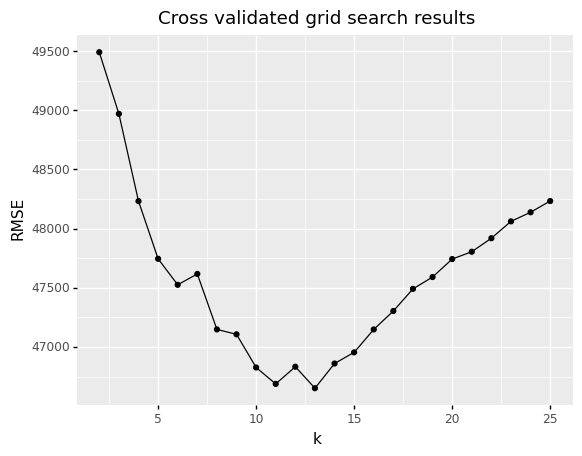

<ggplot: (8763850887961)>

In [70]:
# Plot all RMSE results
all_rmse = pd.DataFrame({
    'k': range(2, 26),
    'RMSE': np.abs(results.cv_results_['mean_test_score'])
    })
    
(ggplot(all_rmse, aes(x='k', y='RMSE'))
 + geom_line()
 + geom_point()
 + ggtitle("Cross validated grid search results"))

# Putting the processes together

You've now been exposed to many of the fundamental pieces of an ML process. The following combines these code snippets into a larger recipe to show you how they all come together. Rather than just look at the 2 features that we included thus far (`Gr_Liv_Area` & `Year_Built`), we'll include all numeric features.

```{note}
To include the categorical features as well we will need to do some feature engineering, which we will discuss in the next session.
```

In [71]:
# create train/test split
train, test = train_test_split(ames, train_size=0.7, random_state=123)

# separate features from labels and only use numeric features
X_train = train.select_dtypes(include='number').drop("Sale_Price", axis=1)
y_train = train["Sale_Price"]

# create KNN model object
knn = KNeighborsRegressor()

# define loss function
loss = 'neg_root_mean_squared_error'

# create 10 fold CV object
kfold = KFold(n_splits=10, random_state=123, shuffle=True)

# Create grid of hyperparameter values
hyper_grid = {'n_neighbors': range(2, 26)}

# Tune a knn model using grid search
grid_search = GridSearchCV(knn, hyper_grid, cv=kfold, scoring=loss)
results = grid_search.fit(X_train, y_train)

# Best model's cross validated RMSE
abs(results.best_score_)

41913.12719017566

In [72]:
# Best model's k value
results.best_estimator_.get_params().get('n_neighbors')

5

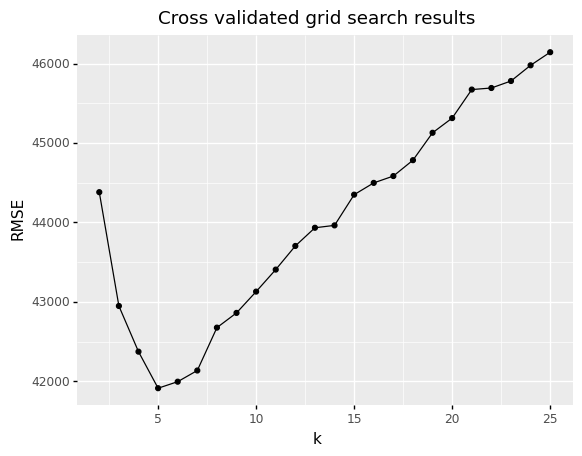

<ggplot: (8763850150060)>

In [73]:
# Plot all RMSE results
all_rmse = pd.DataFrame({
    'k': range(2, 26), 
    'RMSE': np.abs(results.cv_results_['mean_test_score'])
    })
(ggplot(all_rmse, aes(x='k', y='RMSE'))
 + geom_line()
 + geom_point()
 + ggtitle("Cross validated grid search results"))

# References

```{bibliography}
```